In [24]:
from discminer.emulator import Emulator
import discminer.emulator as emulib
import torch
import numpy as np

In [25]:
emu = Emulator(['../../../SCIENCE/UnetEmu/outputs/vr_256/model__epoch_1200_test_vr_256.pth', '../../../SCIENCE/UnetEmu/outputs/vr_256/model__epoch_1200_test_vr_256.pth', '../../../SCIENCE/UnetEmu/outputs/vr_256/model__epoch_1200_test_vr_256.pth'],
               ['../../../SCIENCE/UnetEmu/outputs/vr_256/params.py', '../../../SCIENCE/UnetEmu/outputs/vr_256/params.py', '../../../SCIENCE/UnetEmu/outputs/vr_256/params.py'], ict_gen=emulib.generate_ict_128x128_disc_tri_slopes)

In [26]:
class keplerian_emu(emulib.BaseEmulator):
    def __init__(self, image_size, device='cpu'):
        self.image_size = image_size
        self.device = device
        xy = np.linspace(-3,3, self.image_size)
        xx, yy = np.meshgrid(xy,xy)
        rr = np.sqrt(xx**2+yy**2)
        self.vaz = rr**-0.5
    
    def emulate(self, ic, labels):
        labels = torch.tensor(labels, dtype=torch.float32, device=self.device)
    
        return torch.tensor(self.vaz, device='cpu').reshape(1,1,self.image_size, self.image_size)


In [27]:
emu.emulators[1] = keplerian_emu(256)

/home/aleruzza/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


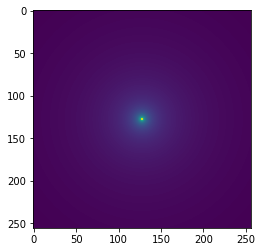

In [6]:
#test
import matplotlib.pyplot as plt
res = emu.emulate(1e-3,0.1,1e-3,1,0.3)
plt.imshow(res[0,1])

# Discminer

In [28]:
#loading the datacube under exam
from discminer.core import Data
from sys import path as syspath
from astropy import units as u
import json
from discminer.mining_utils import get_noise_mask, init_data_and_model
syspath.append('../')
syspath.append('../_mining')

In [29]:
datacube, model = init_data_and_model(Rmin=0, Rmax=1.2)

     _  _                        _                    
  __| |(_) ___   ___  _ __ ___  (_) _ __    ___  _ __ 
 / _` || |/ __| / __|| '_ ` _ \ | || '_ \  / _ \| '__|
| (_| || |\__ \| (__ | | | | | || || | | ||  __/| |   
 \__,_||_||___/ \___||_| |_| |_||_||_| |_| \___||_|   
                                                      

*====================================================================================================*
Computing grid...
Grid maximum extent: 120689578165943.16
Grid step (cell size): 969394202136.0896
*====================================================================================================*
*====================================================================================================*
Computing grid...
Grid maximum extent: 128444731783031.88
Grid step (cell size): 969394202136.0896
*====================================================================================================*
Setting beam_info var to Beam: BMAJ=0.165413767099392 arcse

In [30]:
modelcube = model.make_model(make_convolve=True)

*====================================================================================================*
Running prototype model with the following parameters:

{'height_lower': {'Rb': 803.90594,
                  'p': 1.107099,
                  'q': 2.859784,
                  'z0': 14.227028},
 'height_upper': {'Rb': 108.607483,
                  'p': 1.65208,
                  'q': 0.550336,
                  'z0': 52.680114},
 'intensity': {'I0': 0.10439999999999999,
               'Rout': 717.971915,
               'p': -2.659016,
               'q': 2.156254},
 'lineslope': {'Ls': 1.676401, 'p': 0.314061},
 'linewidth': {'L0': 0.316459, 'p': -0.288951, 'q': -0.355926},
 'orientation': {'PA': 1.010296,
                 'incl': -0.672928,
                 'xc': -0.91338,
                 'yc': -1.826827},
 'velocity': {'Mstar': 1.973085, 'vel_sign': -1.0, 'vsys': 5.099463}}

*====================================================================================================*
*=====

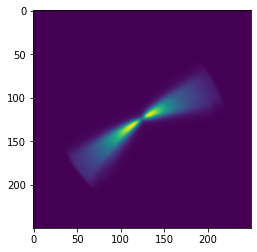

In [31]:
import matplotlib.pyplot as plt
plt.imshow(modelcube.data[65])

In [33]:
from discminer import units as ucf

In [45]:
emu_params = {
    'alpha': 1e-3,
    'h': 0.05,
    'planetMass': 1e-2,
    'sigmaSlope': 1,
    'flaringIndex': 0.25,
    'R_p': 150*ucf.au,
    'phi_p':-np.pi/4,
    'extrap_vfunc': model.keplerian
}

In [46]:
model.velocity_func = emu.emulate_v3d
model.params['velocity'].update(emu_params)
model.params['orientation']['incl'] = -45 

Setting velocity function to <bound method Emulator.emulate_v3d of <discminer.emulator.Emulator object at 0x7f768dcfc7f0>>


In [50]:
modelcube2 = model.make_model(make_convolve=False)

*====================================================================================================*
Running prototype model with the following parameters:

{'height_lower': {'Rb': 803.90594,
                  'p': 1.107099,
                  'q': 2.859784,
                  'z0': 14.227028},
 'height_upper': {'Rb': 108.607483,
                  'p': 1.65208,
                  'q': 0.550336,
                  'z0': 52.680114},
 'intensity': {'I0': 0.10439999999999999,
               'Rout': 717.971915,
               'p': -2.659016,
               'q': 2.156254},
 'lineslope': {'Ls': 1.676401, 'p': 0.314061},
 'linewidth': {'L0': 0.316459, 'p': -0.288951, 'q': -0.355926},
 'orientation': {'PA': 1.010296, 'incl': -45, 'xc': -0.91338, 'yc': -1.826827},
 'velocity': {'Mstar': 1.973085,
              'R_p': 22439680605000.0,
              'alpha': 0.001,
              'extrap_vfunc': <function Velocity.keplerian at 0x7f76993b6dd0>,
              'flaringIndex': 0.25,
              'h': 0

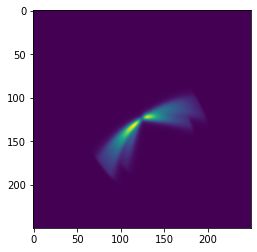

In [49]:
plt.imshow(modelcube2.data[64])